In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 

## Exploring the database and retrieving the data

The data is stored in a SQlite database identifier.sqlite. Let's explore the database to see what tables are available.

In [2]:
conn = sqlite3.connect('data/identifier.sqlite')
pd.read_sql("SELECT name FROM sqlite_master", conn)

,name
0,customer_churn


In [4]:
pd.read_sql("PRAGMA table_info(customer_churn)", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,call_failure,INTEGER,0,None,0
1,1,complains,INTEGER,0,None,0
2,2,subscription_length,INTEGER,0,None,0
3,3,charge_amount,INTEGER,0,None,0
4,4,seconds_of_use,INTEGER,0,None,0
5,5,frequency_of_use,INTEGER,0,None,0
6,6,frequency_of_sms,INTEGER,0,None,0
7,7,distinct_called_numbers,INTEGER,0,None,0
8,8,age_group,INTEGER,0,None,0
9,9,tariff_plan,INTEGER,0,None,0


from the above result we can see that there are no null values in the data. Is that true? we find it later.

In [4]:
pd.read_sql("SELECT * FROM customer_churn LIMIT 10", conn)

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,age_group,tariff_plan,status,age,customer_value,churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
5,11,0,38,1,3775,82,32,28,3,1,1,30,282.280,0
6,4,0,38,0,2360,39,285,18,3,1,1,30,1235.960,0
7,13,0,37,2,9115,121,144,43,3,1,1,30,945.440,0
8,7,0,38,0,13773,169,0,44,3,1,1,30,557.680,0
9,7,0,38,1,4515,83,2,25,3,1,1,30,191.920,0


Now we have to read this data as a pandas dataframe. But We don't take all columns. 

 - There is two columns on age. So we only take Age Group here because before feeding the data into the machine learning model, we have to encode that column which is already done here.
 
 - We are ignoring **call_failure**, **subscription_length**, **charge_amount**, **tariff_plan** as they are not so much useful for determining about customer churn.

In [5]:
query = "SELECT complains, charge_amount, seconds_of_use, frequency_of_use, frequency_of_sms, age_group, customer_value, churn FROM customer_churn"

tel_data = pd.read_sql(query, conn)
tel_data.head()

,complains,charge_amount,seconds_of_use,frequency_of_use,frequency_of_sms,age_group,customer_value,churn
0,0,0,4370,71,5,3,197.640,0
1,0,0,318,5,7,2,46.035,0
2,0,0,2453,60,359,3,1536.520,0
3,0,0,4198,66,1,1,240.020,0
4,0,0,2393,58,2,1,145.805,0


## Data Analysis

Now let's get some insights about the data.

In [6]:
tel_data[["seconds_of_use", "frequency_of_use", "frequency_of_sms", "customer_value"]].describe()

,seconds_of_use,frequency_of_use,frequency_of_sms,customer_value
count,3150.000000,3150.000000,3150.000000,3150.000000
mean,4472.459683,69.460635,73.174921,470.972916
std,4197.908687,57.413308,112.237560,517.015433
min,0.000000,0.000000,0.000000,0.000000
25%,1391.250000,27.000000,6.000000,113.801250
50%,2990.000000,54.000000,21.000000,228.480000
75%,6478.250000,95.000000,87.000000,788.388750
max,17090.000000,255.000000,522.000000,2165.280000


It seems that, **seconds_of_use**, **frequency_of_use**, **frequency_of_sms** and the **customer_value** column has the minimum value of 0. It may be happen that they are the new customers or the missing values of this columns are present in those columns as 0. 
Let's find out!

In [21]:
zero_data = tel_data[tel_data['seconds_of_use'] == 0]
zero_data

,complains,charge_amount,seconds_of_use,frequency_of_use,frequency_of_sms,age_group,customer_value,churn
0,0,0,4370,71,5,3,197.640,0
1,0,0,318,5,7,2,46.035,0
2,0,0,2453,60,359,3,1536.520,0
3,0,0,4198,66,1,1,240.020,0
4,0,0,2393,58,2,1,145.805,0
...,...,...,...,...,...,...,...,...
3145,0,2,6697,147,92,2,721.980,0
3146,0,1,9237,177,80,5,261.210,0
3147,0,4,3157,51,38,3,280.320,0
3148,0,2,4695,46,222,3,1077.640,0


In [8]:
assert \
tel_data[tel_data['seconds_of_use'] == 0].shape[0] == \
tel_data[tel_data['frequency_of_use'] == 0].shape[0]

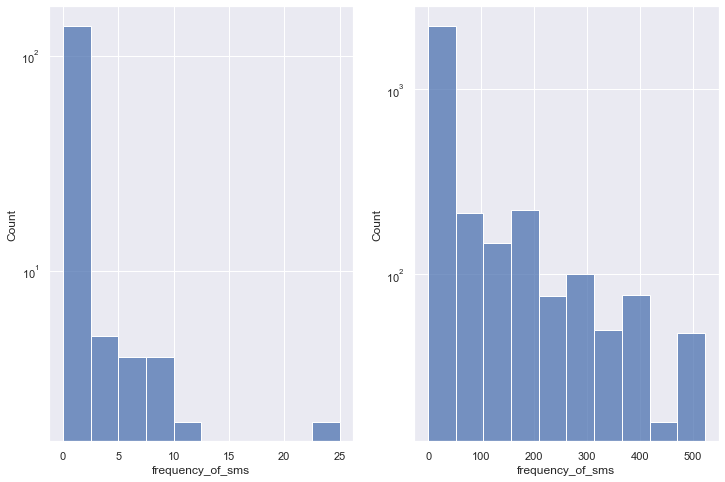

In [19]:
sns.set()
fig,ax = plt.subplots(1, 2, figsize=(12,8))
sns.histplot(x='frequency_of_sms', data=zero_data, ax=ax[0], bins=10)
sns.histplot(x='frequency_of_sms', data=tel_data, ax=ax[1], bins=10)
ax[0].set(yscale='log')
ax[1].set(yscale='log')
plt.show()

while checking that how many rows are there where **seconds_of_use** column is zero, I also notice that there are also **frequency_of_use** column have the same value. But some of them are used the SMS pack. While we are taking a new connection, we have to do some messaging work for activating the connection or they are just started to used their connections. 

We can easily notice the difference between the above two plots. The left plot is drawn on that part of the dataset where **seconds_of_use** and **frequency_of_use** columns contain the value zero. The other one is drawn on the whole dataset. The first plot has the max value of SMS is 25 but in the other plot this max value is more than 500! so we now came to that inference that the zero values in those columns are not missing values, those indicates that they are the new customers.

And yes, one more thing! is there any column containing mixed value?

In [ ]:
tel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   complains         3150 non-null   int64  
 1   charge_amount     3150 non-null   int64  
 2   seconds_of_use    3150 non-null   int64  
 3   frequency_of_use  3150 non-null   int64  
 4   frequency_of_sms  3150 non-null   int64  
 5   age_group         3150 non-null   int64  
 6   customer_value    3150 non-null   float64
 7   churn             3150 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 197.0 KB


from the above result, we can easily say that there is no column containing mixed value. Now we have to check that if the data is imbalanced or not.

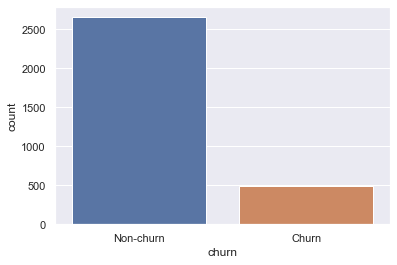

In [ ]:
sns.countplot(x='churn', data=tel_data)
plt.xticks([0, 1], ['Non-churn', 'Churn'])
plt.show()

The result is as expected. There is more data on Non-churn customer than the churned customer. As we are interested in predicting the churned customer, we have to deal with this imbalanced data later.

Now this data contains 8 columns. Are all of them important? Let's see by finding the correlation matrix.

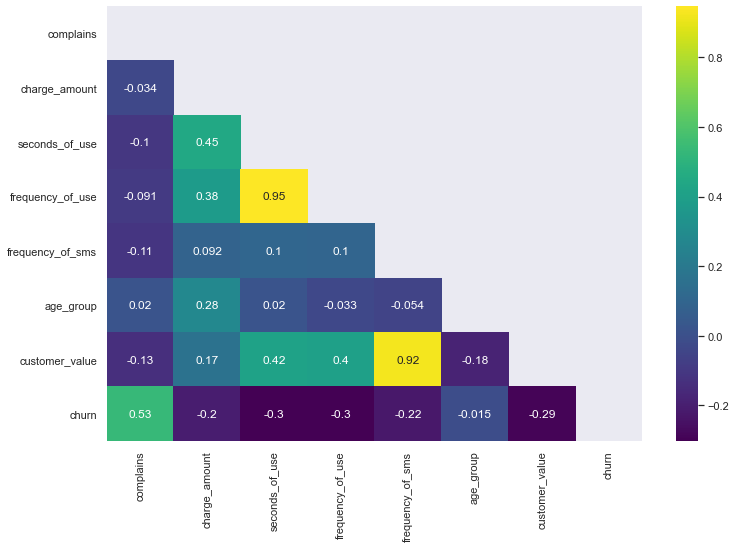

In [ ]:
import numpy as np
plt.figure(figsize=(12,8))
corr = tel_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask, cmap='viridis')
plt.show()

From the correlation matrix, we can easily notice that 

 - **frequency_of_use** and **seconds_of_use** has the high positive correlation between them. So we can put any one of them in the data.

In [ ]:
tel_data_selected = tel_data.drop('frequency_of_use', axis=1)

tel_data_selected.head()

,complains,charge_amount,seconds_of_use,frequency_of_sms,age_group,customer_value,churn
0,0,0,4370,5,3,197.640,0
1,0,0,318,7,2,46.035,0
2,0,0,2453,359,3,1536.520,0
3,0,0,4198,1,1,240.020,0
4,0,0,2393,2,1,145.805,0


## Dealing with Imbalanceness
Now we are going to check how much data are present for churned and non-churned customers.

In [ ]:
churned = tel_data_selected[tel_data_selected['churn']==1]
not_churned = tel_data_selected[tel_data_selected['churn']==0]

print('percentage of churned customer: {}'.format(churned.shape[0]/tel_data_selected.shape[0]))
print('percentage of not-churned customer: {}'.format(not_churned.shape[0]/tel_data_selected.shape[0]))

percentage of churned customer: 0.15714285714285714
percentage of not-churned customer: 0.8428571428571429


Hmm, only 15% data are related to the churned customers and 84% data are related to non-churned customer. That's a great difference. We have to oversample the minority class. For doing this, I am using SMOTE(**S**ynthetic **M**inority **O**ver-sampling **T**echniqu**E**) which make synthetic data using the characteristics of the nearest neighbors. This technique is available in the *imblearn* python library.

There is also one thing. We don't want to test the ml model on a fake data! So I am using this technique only on the training data. For this, we are splitting the data using train_test_split from *scikit-learn*. 

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [ ]:
X = tel_data_selected.drop('churn', axis=1)
y = tel_data_selected['churn']

resampler = SMOTE(random_state=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

In [ ]:
from collections import Counter

print('Resampled dataset shape %s' % Counter(y_resampled))

Resampled dataset shape Counter({0: 2124, 1: 2124})


Now the data has the same quantity of positive class as well as negative class. 

After that, we have to scale all the columns so that the columns are in the same range. **seconds_of_use**, **frequency_of_sms** and the **customer_value** columns are the numeric columns. Other columns are encoded categorical columns. So we have to scale only these 3 columns. For selecting the specific column for scaling I am using *ColumnTransformer* from scikit-learn and *StandardScaler* for scaling.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    [('scaler', StandardScaler(), ['seconds_of_use', 'frequency_of_sms', 'customer_value'])], remainder='passthrough')

X_scaled = ct.fit_transform(X_resampled)

In [ ]:
X_test_scaled = ct.transform(X_test)

## Model Training

Now its the time for model training. Here I am using the *LogisticRegression* for classification.

In [ ]:
from sklearn.linear_model import LogisticRegression

linear_reg = LogisticRegression()
linear_reg.fit(X_scaled, y_resampled)

LogisticRegression()

In [ ]:
y_pred = linear_reg.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       531
           1       0.37      0.85      0.51        99

    accuracy                           0.75       630
   macro avg       0.67      0.79      0.67       630
weighted avg       0.87      0.75      0.78       630



As we have to determine which customer is going to give up the telecom service, we have to take *recall* as the evaluation metric. From the above classification report, we can clearly see that the model gives the decent score for predicting the customer as churned, which is indeed good.

Now let's plot the *Confusion Matrix*.

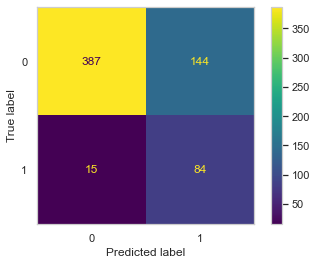

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

From the 99 churned customer samples, we are detecting 84 samples correctly and 15 are misclassified. This result might change in multiple reruns.

Wht happens if we just pass the data without resampling? Let's see. 

In [ ]:
X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)

linear_reg.fit(X_train_scaled, y_train)
y_pred2 = linear_reg.predict(X_test_scaled)

print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       531
           1       0.93      0.39      0.55        99

    accuracy                           0.90       630
   macro avg       0.91      0.69      0.75       630
weighted avg       0.90      0.90      0.88       630



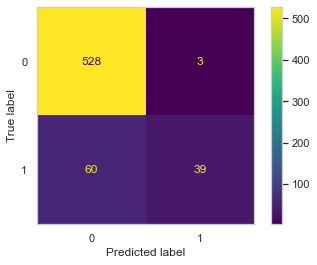

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred2)
plt.show()

From the recall and the confusion matrix, we can clearly see that this model is not working well for detecting the churned customer.

# Conclusion

So, we can see from the above result that here the resampling technique gives the better result in predicting the churned customers. And from the analysis, we can see that not all features are important here. I take only 6 features out of 14 features but still model gives the decent result. 

# Future Improvements

This model can be improved by tuning the hyperparameters or using other algorithm other than *LogisticRegression*. We can also apply *Cross-Validation* for taking the best split of the data for training.